# Miscellaneous

This is a notebook for plotting various plots, each with its own header. They are not necessarily *tests*, but rather they are useful explaining various topics in a paper.

 - FUV calculation
 - Galactic cosmic ray ionisation rate
 - Fixsen et al. (1998) data
 - HEALPIX viewing
 - Regridding in cygrid
 - RMS calculation

## 

### FUV calculation

Here we can calculate the various descriptions of the far-UV energy density as a function of wavelength. This has been migrated to a python package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as con

from astropy.io import fits
from astropy.modeling.models import BlackBody
from copy import copy
from scipy.interpolate import interp1d

c = 2.9979e10

def u_habing(l):
    return (-25/6*(l/1e3)**3 + 25/2*(l/1e3)**2 - 13/3*l/1e3)*1e-14

def u_draine(l, chi=1.71, test=False):
    if test:
        return 4e-14 * (53.05461*(l/1e3)**-3 - 85.37824*(l/1e3)**-4 + 34.03412*(l/1e3)**-5)
    else:
        return 4e-14 * chi * (31.02609*(l/1e3)**-3 - 49.92879*(l/1e3)**-4 + 19.90300*(l/1e3)**-5)

def u_mezger(l):
    ul = np.zeros(*l.shape)
    i = (l>1340) & (l<=2460)
    ul[i] = 2.373e-14 * (l[i]/1e4)**-0.6678
    i = (l>1100) & (l<=1340)
    ul[i] = 6.825e-13 * (l[i]/1e4)
    i = (l>=912) & (l<=1100)
    ul[i] = 1.287e-9 * (l[i]/1e4)**4.4172
    return ul

def u_kosma(l, **kwargs):
    ul = u_draine(l, **kwargs)
    i = l >= 2000
    ul[i] = 1.39148e-5/c * l[i]**0.7
    return ul

def u_zucconi(l, temp=0, scale=0):
    ul = (2*con.h*con.c/l**3/u.AA**3).to(u.g/u.s**2).value * w / (np.exp(con.h*con.c/l/u.AA/con.k_B/t/u.K).value - 1)
    return ul

#### Draine (1978)

In [2]:
import astropy.constants as con

c1 = ((4*np.pi*u.sr*con.h**2*con.c)/(1e3*u.AA)**2 * 1.658e6*(1/u.cm**2/u.s/u.sr/u.eV) * (con.h*con.c/1e3/u.AA/u.eV)**1 / 6.84e-14).to(u.erg/u.cm**3)
c2 = ((4*np.pi*u.sr*con.h**2*con.c)/(1e3*u.AA)**2 * 2.152e5*(1/u.cm**2/u.s/u.sr/u.eV) * (con.h*con.c/1e3/u.AA/u.eV)**2 / 6.84e-14).to(u.erg/u.cm**3)
c3 = ((4*np.pi*u.sr*con.h**2*con.c)/(1e3*u.AA)**2 * 6.919e3*(1/u.cm**2/u.s/u.sr/u.eV) * (con.h*con.c/1e3/u.AA/u.eV)**3 / 6.84e-14).to(u.erg/u.cm**3)

print(c1)
print(c2)
print(c3)

31.026086231352096 erg / cm3
49.928793832798185 erg / cm3
19.90299696776124 erg / cm3


In [3]:
import astropy.constants as con

c1 = ((4*np.pi*u.sr*con.h**2*con.c)/(1e3*u.AA)**2 * 1.658e6*(1/u.cm**2/u.s/u.sr/u.eV) * (con.h*con.c/1e3/u.AA/u.eV)**1 / 4e-14).to(u.erg/u.cm**3)
c2 = ((4*np.pi*u.sr*con.h**2*con.c)/(1e3*u.AA)**2 * 2.152e5*(1/u.cm**2/u.s/u.sr/u.eV) * (con.h*con.c/1e3/u.AA/u.eV)**2 / 4e-14).to(u.erg/u.cm**3)
c3 = ((4*np.pi*u.sr*con.h**2*con.c)/(1e3*u.AA)**2 * 6.919e3*(1/u.cm**2/u.s/u.sr/u.eV) * (con.h*con.c/1e3/u.AA/u.eV)**3 / 4e-14).to(u.erg/u.cm**3)

print(c1)
print(c2)
print(c3)

53.05460745561209 erg / cm3
85.3782374540849 erg / cm3
34.034124814871724 erg / cm3


#### van Dishoek & Black (1982)

In [4]:
(2.44e-16*(1e-10)**2.7*(1/u.cm**2/u.s/u.Hz) * con.h*con.c/(1e-10*u.AA)**2).to(u.erg/u.cm**3)*(con.c.to(u.cm/u.s))

<Quantity 1.45307243e-12 erg / (cm2 s)>

In [5]:
(con.h*con.c/5/u.eV).to(u.AA)

<Quantity 2479.68396866 Angstrom>

In [6]:
(con.h*con.c/1e3/u.AA).to(u.eV)

<Quantity 12.39841984 eV>

#### All spectra

Draine chi factor: 1.710489999999993

4.614383335124606e-16


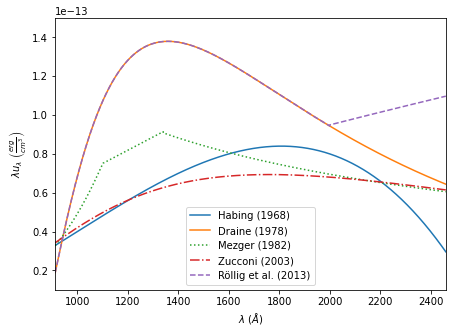

In [2]:
print('Draine chi factor:', u_draine(1000, test=True)/4e-14)
print('')

print(u_draine(2000, chi=1.71)/2000**0.7)

wavelengths = np.linspace(912, 2460, num=10000)

t = 29000
w = 1.5e-11

fig, ax = plt.subplots(1, 1, figsize=(7,5))

ax.plot(wavelengths, u_habing(wavelengths), label='Habing (1968)')
ax.plot(wavelengths, u_draine(wavelengths), label='Draine (1978)')
ax.plot(wavelengths, u_mezger(wavelengths), ls=':', label='Mezger (1982)')
ax.plot(wavelengths, u_zucconi(wavelengths, temp=t, scale=w), ls='-.', label='Zucconi (2003)')
ax.plot(wavelengths, u_kosma(wavelengths), ls='--', label='Röllig et al. (2013)')

ax.set_xlim(912, 2460)
ax.set_ylim(1e-14, 1.5e-13)

ax.set_xlabel(r'$\lambda \ (\AA)$')
ax.set_ylabel(r'$\lambda u_\lambda \ \left( \frac{erg}{cm^3} \right)$')

ax.legend()

plt.show()
plt.close()

In [3]:
np.trapz(u_kosma(wavelengths), wavelengths)

1.6984207950365882e-10

## 

### Galactic primary cosmic ray ionisation rate (Wolfire et al., 2003)

solar zeta_H: 1.9990938600297133e-16


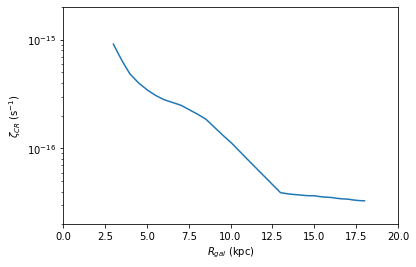

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d

hi_dat = np.genfromtxt('/home/yanitski/kosmatau3d/kosmatau3d/input/MilkyWay/mass_profile_inter.dat', names=['r', 'hi'])
h2_dat = np.genfromtxt('/home/yanitski/kosmatau3d/kosmatau3d/input/MilkyWay/mass_profile.dat', names=['r', 'h2'])

hi_interp = interp1d(hi_dat['r'], hi_dat['hi'], kind='linear')
h2_interp = interp1d(h2_dat['r'], h2_dat['h2'], kind='linear')

r_sun = 8.178
zeta_sun = 2e-16
Hp = 3.500

radius = np.linspace(3, 18, num=1000)
zeta = zeta_sun * np.exp(-(radius-r_sun)/Hp) * (hi_interp(r_sun)+h2_interp(r_sun)) / (hi_interp(radius)+h2_interp(radius))
i = np.argmin(np.abs(radius-8.178))
print('solar zeta_H:', zeta[i])

plt.semilogy(radius, zeta)
plt.xlabel(r'$R_{gal}$ (kpc)')
plt.ylabel(r'$\zeta_{CR}$ (s$^{-1}$)')
plt.ylim([0.1*zeta_sun, 10*zeta_sun])
plt.xlim([0, 20]) ;

## 

### Fixsen et al (1998) data

This is the Milky Way plane data from *COBE-FIRAS* that is used in the model comparison for the `kosmatau3d` paper.

[b'CO 1-0' b'CO 2-1' b'CO 3-2' b'O_2' b'CO 4-3' b'C^0 (609)' b'Ortho H_2O'
 b'CO 5-4' b'CO 6-5' b'CO 7-6 +C^0 (370)' b'Para H_2O' b'N^+ (205)'
 b'Para H_2O' b'C^+' b'O_0' b'Si_0' b'N^+' b'CH' b'CO 8-7']


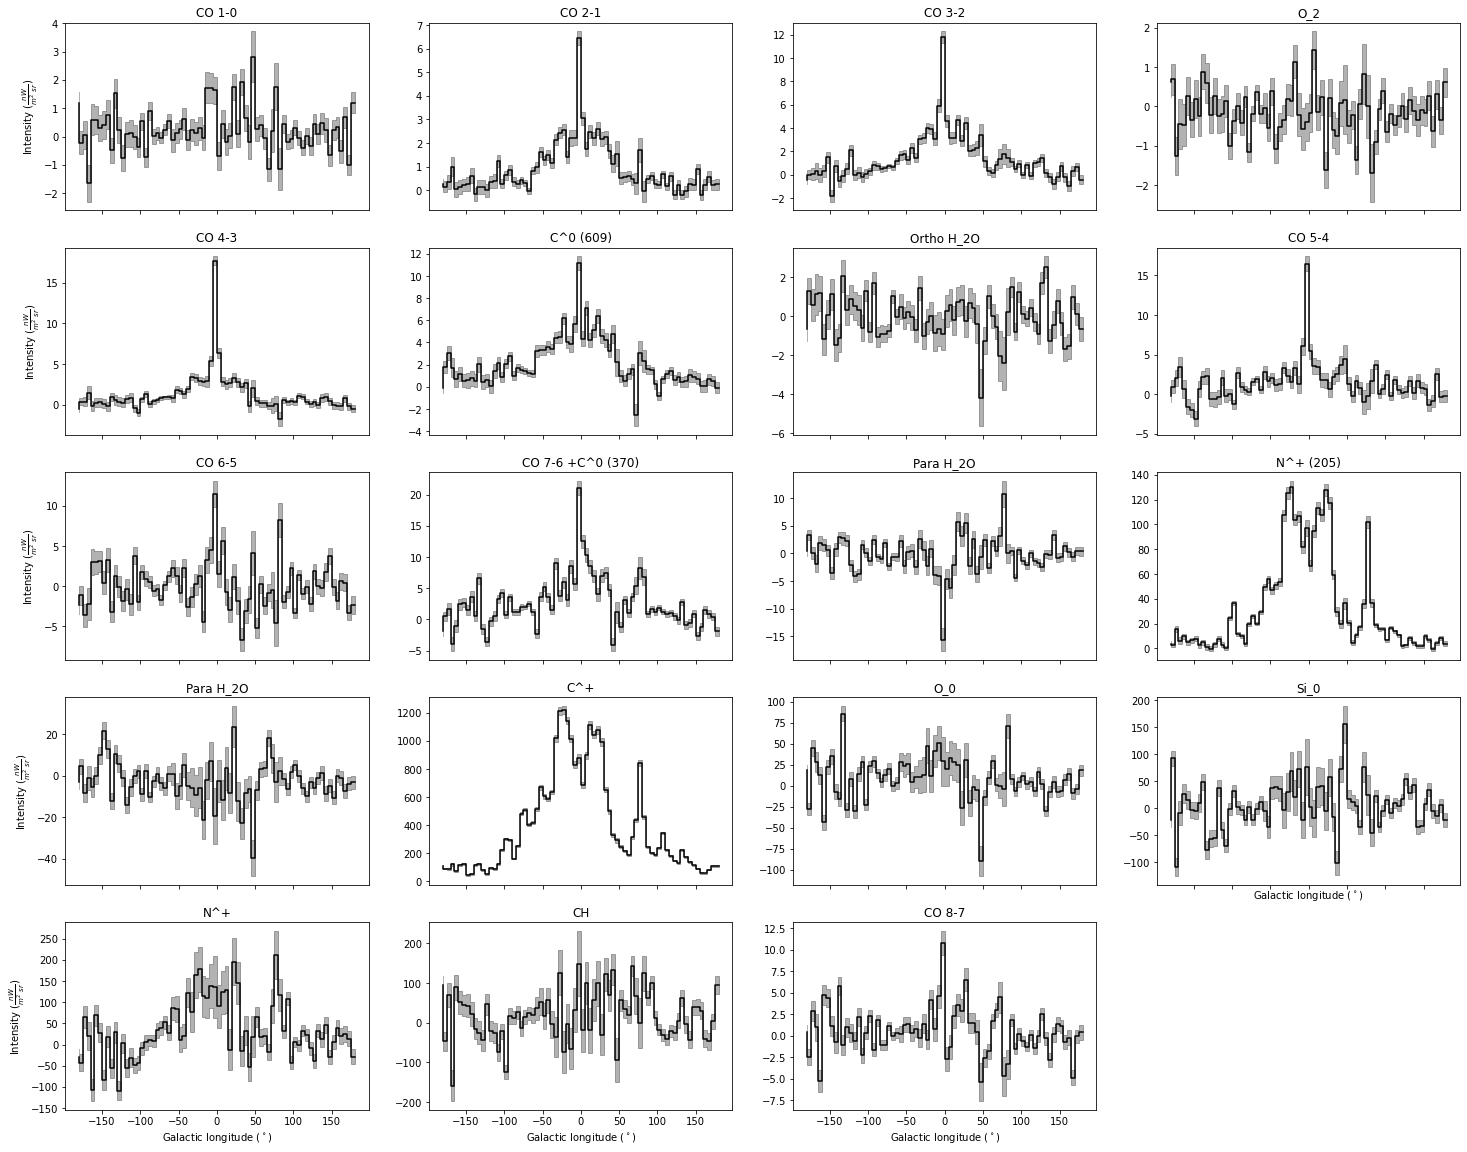

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav

data = readsav('/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/COBE-FIRAS/regridded/temp/craig.idl')
print(data['line'])
i = np.where(data['line'] == b'C^+')[0]
fig, axes = plt.subplots(5, 4, figsize=(25, 20), sharex=True)
# fig.gca(xlabel=r'Galactic longitude $(^\circ)$', ylabel=r'Intensity $(\frac{nW}{m^2 \ sr})$')
axes = axes.flatten()
axes[-1].remove()
for i in range(data['line'].size):
    if i< 19:
        axes[i].step(data['long'], data['amplitude'][:, i], color='xkcd:black')
        axes[i].fill_between(data['long'], data['amplitude'][:, i]-data['sigma'][:, i], data['amplitude'][:, i]+data['sigma'][:, i], step='pre', color='xkcd:black', lw=1, alpha=0.3)
        axes[i].set_title(data['line'][i].decode('utf-8'))
    else:
        axes[i].step(data['long'], data['amplitude'].sum(1), color='xkcd:black')
        axes[i].fill_between(data['long'], data['amplitude'].sum(1)-data['sigma'].sum(1), data['amplitude'].sum(1)+data['sigma'].sum(1), step='pre', color='xkcd:black', lw=1, alpha=0.3)
        axes[i].set_title('Total IR emission')
axes[16].set_xlabel(r'Galactic longitude $(^\circ)$')
axes[17].set_xlabel(r'Galactic longitude $(^\circ)$')
axes[18].set_xlabel(r'Galactic longitude $(^\circ)$')
axes[15].set_xlabel(r'Galactic longitude $(^\circ)$')
axes[0].set_ylabel(r'Intensity $(\frac{nW}{m^2 \ sr})$')
axes[4].set_ylabel(r'Intensity $(\frac{nW}{m^2 \ sr})$')
axes[8].set_ylabel(r'Intensity $(\frac{nW}{m^2 \ sr})$')
axes[12].set_ylabel(r'Intensity $(\frac{nW}{m^2 \ sr})$')
axes[16].set_ylabel(r'Intensity $(\frac{nW}{m^2 \ sr})$')
plt.show()
plt.savefig('/home/yanitski/projects/pdr/COBE-FIRAS_galactic_plane.png')
plt.close()

## 

## HEALPIX handling

In [130]:
from astropy.io import fits
from pprint import pprint
import os
import numpy as np

directory = '/media/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/Planck/'
files = os.listdir(directory)
planck = fits.open(directory+files[0])
# linfrq = np.array([cobe[0].header['LINFRQ1'], cobe[0].header['LINFRQ2'], cobe[0].header['LINFRQ3'],
#                    cobe[0].header['LINFRQ4'], cobe[0].header['LINFRQ5'], cobe[0].header['LINFRQ6'],
#                    cobe[0].header['LINFRQ7'], cobe[0].header['LINFRQ8'], cobe[0].header['LINFRQ9'],
#                    cobe[0].header['LINFRQ10']])
# print(type(cobe[0].header['LINFRQ1']))
pprint(planck[0].header)
print()
pprint(planck[1].header)
print(planck[1].data['I_ML'].shape)

SIMPLE  =                    T / Written by IDL:  Thu Dec 11 13:07:57 2014      
BITPIX  =                    8 /Dummy primary header created by MWRFITS         
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               
CHECKSUM= 'NAdRN1dQN8dQN8dQ'   / HDU checksum created 2014-12-11T12:07:58       

XTENSION= 'BINTABLE'           /Written by IDL:  Thu Dec 11 13:07:57 2014       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                   36 /Number of bytes per row                         
NAXIS2  =               786432 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                  

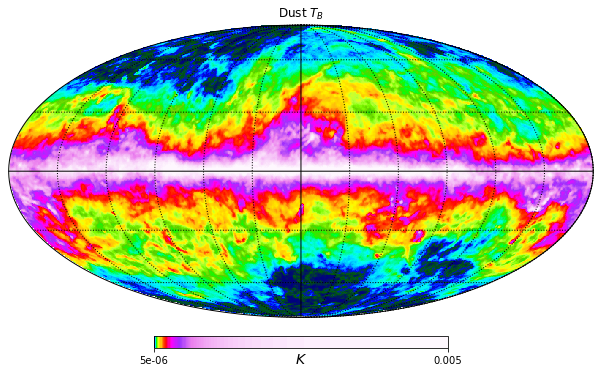

In [200]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
# print(np.degrees(hp.nside2resol(NSIDE)))

lat,lon = np.degrees(hp.pix2ang(nside=NSIDE, ipix=np.arange(NPIX), nest=True))
lat = 90-lat
# print(lon.min(), lon.max(), lat.min(), lat.max(), lon.size)

obs_data = planck[1].data['I_ML'] / 1e6
hp.mollview(obs_data, NSIDE, nest=True, cmap='gist_ncar', norm='hist', min=5e-6, max=5e-3,
#             coord=('G', 'E'), 
            title=r'Dust $T_{B}$', unit=r'$K$')
hp.graticule()
# hp.mollview(lat, NSIDE, nest=True, cmap='gist_ncar')
# hp.mollview(lon, NSIDE, nest=True, cmap='gist_ncar')

SIMPLE  =                    T / Generated by Aladin (CDS)                      
BITPIX  =                  -64 / Bits per pixel                                 
NAXIS   =                    2 / Number of dimensions                           
NAXIS1  =                  584 / Length of x axis                               
NAXIS2  =                  217 / Length of y axis                               
COMMENT This astrometrical calibration was computed via Aladin                  
CRPIX1  =           277.083584                                                  
CRPIX2  =   113.08358399999999                                                  
EQUINOX =               2000.0                                                  
CRVAL1  =  0.04898963155600715                                                  
CRVAL2  = -0.26754182141905164                                                  
CTYPE1  = 'GLON-AIT'                                                            
CTYPE2  = 'GLAT-AIT'        

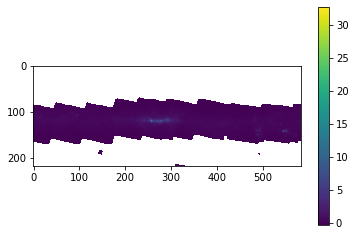

In [209]:
file = fits.open('/home/yanitski/ESAVO-P-HERSCHEL-PACS160~1.fits')
pprint(file[0].header)
cm = plt.imshow(file[0].data)
plt.colorbar(cm)

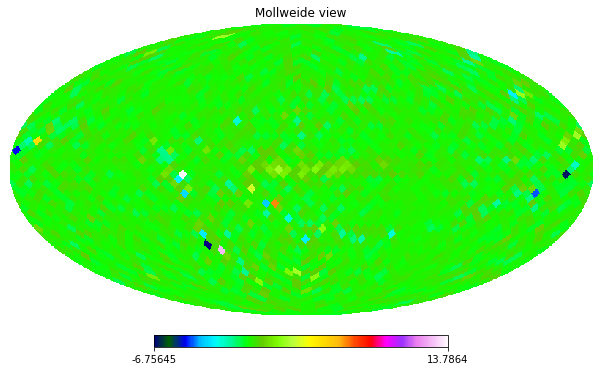

In [125]:
NSIDE = 16
NPIX = hp.nside2npix(NSIDE)

lon = np.radians(cobe[1].data['GAL_LON'])
lat = np.radians(90-cobe[1].data['GAL_LAT'])
linfrq = np.array([float(cobe[0].header[key]) for key in cobe[0].header.keys() if 'LINFRQ' in key])
data = cobe[1].data['LINE_FLU'] * (2.9979**3) / (linfrq**3) / 2 / 1.38 * 10 ** 8
trj = data[:, 8]

pixel_indices = hp.ang2pix(NSIDE, lat, lon)
tmap = np.zeros(hp.nside2npix(NSIDE))
tmap[pixel_indices] = trj
hp.mollview(tmap, cmap='gist_ncar')

In [128]:
hp.nside2resol(16) *180/np.pi

3.6645188392718997

In [ ]:
import cygrid as cg

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=wcs.celestial)
lon, lat = ax.coords
lon.set_axislabel('Galactic Longitude')
lat.set_axislabel('Galactic Latitude')
ax.imshow(datacube, **imkw)
ax.coords.grid(color='white', alpha=0.5, linestyle='solid')

In [71]:
cobe[1].data['GAL_LAT'].max()

88.38035

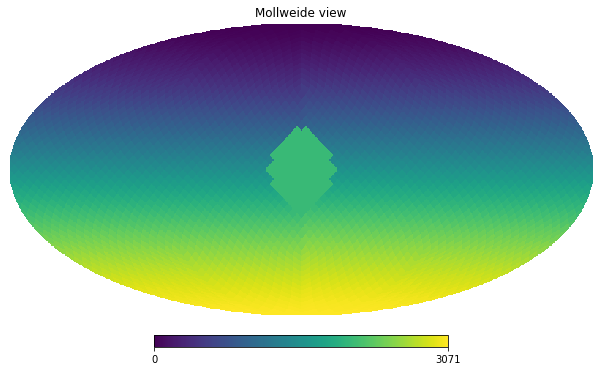

In [55]:
NSIDE = 16
NPIX = hp.nside2npix(NSIDE)

m = np.arange(NPIX)
idx = hp.query_disc(nside=NSIDE, vec=hp.ang2vec(np.pi/2, 0), radius=np.radians(20))
m[idx] = m[idx].max()
hp.mollview(m, NSIDE)

In [68]:
hp.nside2npix(16)

3072

In [56]:
map = hp.read_map('/media/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/COBE-FIRAS/FIRAS_LINE_EMISSION_MAP_HIGH.FITS')

/home/yanitski/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/yanitski/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:385: HealpixFitsWarning: No NSIDE in the header file : will use length of array
  warnings.warn(


TypeError: unsupported format string passed to NoneType.__format__

In [7]:
from astropy.io import fits
from pprint import pprint
import os
import numpy as np

directory = '/media/4,0 TB Hard Disk/yanitski/projects/pdr/observational_data/MilkyWay/COBE_FIRAS/'
files = os.listdir(directory)
cobe = fits.open(directory+files[1])
# linfrq = np.array([cobe[0].header['LINFRQ1'], cobe[0].header['LINFRQ2'], cobe[0].header['LINFRQ3'],
#                    cobe[0].header['LINFRQ4'], cobe[0].header['LINFRQ5'], cobe[0].header['LINFRQ6'],
#                    cobe[0].header['LINFRQ7'], cobe[0].header['LINFRQ8'], cobe[0].header['LINFRQ9'],
#                    cobe[0].header['LINFRQ10']])
# print(type(cobe[0].header['LINFRQ1']))
pprint(cobe[0].header)
print(cobe[1].data[:3])

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
DATE    = '28/09/97'           / FITS file creation date (dd/mm/yy)             
ORIGIN  = 'CDAC    '           /  Cosmology Data Analysis Center                
TELESCOP= 'COBE    '           /  COsmic Background Explorer satellite          
INSTRUME= 'FIRAS   '           /  COBE instrument [DIRBE, DMR, FIRAS]           
OBJECT  = 'ALL-SKY '        

In [26]:
from astropy.io import fits
from pprint import pprint
import os
import numpy as np

directory = '/media/4,0 TB Hard Disk/yanitski/projects/pdr/observational_data/MilkyWay/COBE_FIRAS/'
spec = [10, 8, 8]
files = os.listdir(directory)
for i,file in enumerate(files):
    cobe = fits.open(directory+file)
    linfrq = np.array([cobe[0].header['LINFRQ{}'.format(j+1)] for j in range(spec[i])])
    print(file)
    print()
    print(linfrq)
    print()
    pprint(cobe[0].header)
    print()
    pprint(cobe[1].header)
    print()
    print(cobe[1].data['LINE_FLU'][0])
    print('\n--------------------\n')

FIRAS_LINE_EMISSION_MAP_HIGH.FITS

[ 691.47  809.44 1113.3  1461.1  1716.6  1900.5  2060.1  2311.7  2459.4
 2589.6 ]

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
DATE    = '03/12/97'           / FITS file creation date (dd/mm/yy)             
ORIGIN  = 'CDAC    '           /  Cosmology Data Analysis Center                
TELESCOP= 'COBE    '           /  COsmic Background Explorer satellite  

## 

# `cygrid` regridding

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from pprint import pprint

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.utils.data import conf
from astropy.wcs import WCS
from astroquery.skyview import SkyView

import cygrid

# We'll be loading some data from skyview, hence the longer timeout
conf.remote_timeout = 60.

In [5]:
params = {
    'backend': 'pdf',
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.family': 'serif',
    'figure.dpi': 75
}

rcParams.update(params)

In [6]:
imkw = dict(
    origin='lower', interpolation='nearest',
    )

In [7]:
paths = SkyView().get_images(
    position='177., 61.',
    coordinates='J2000',
    pixels='500',
    scaling='Linear',
    survey=['Planck 857 I'],
    )

In [8]:
input_header, input_data = paths[0][0].header, paths[0][0].data

In [9]:
pprint(input_header)

SIMPLE  =                    T / Written by SkyView Mon Jun 28 07:25:15 EDT 2021
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                  500 / Width of image                                 
NAXIS2  =                  500 / Height of image                                
CRVAL1  =               177.25 / Reference longitude                            
CRVAL2  =                61.25 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                           
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =                250.5 / X reference pixel                              
CRPIX2  =                250

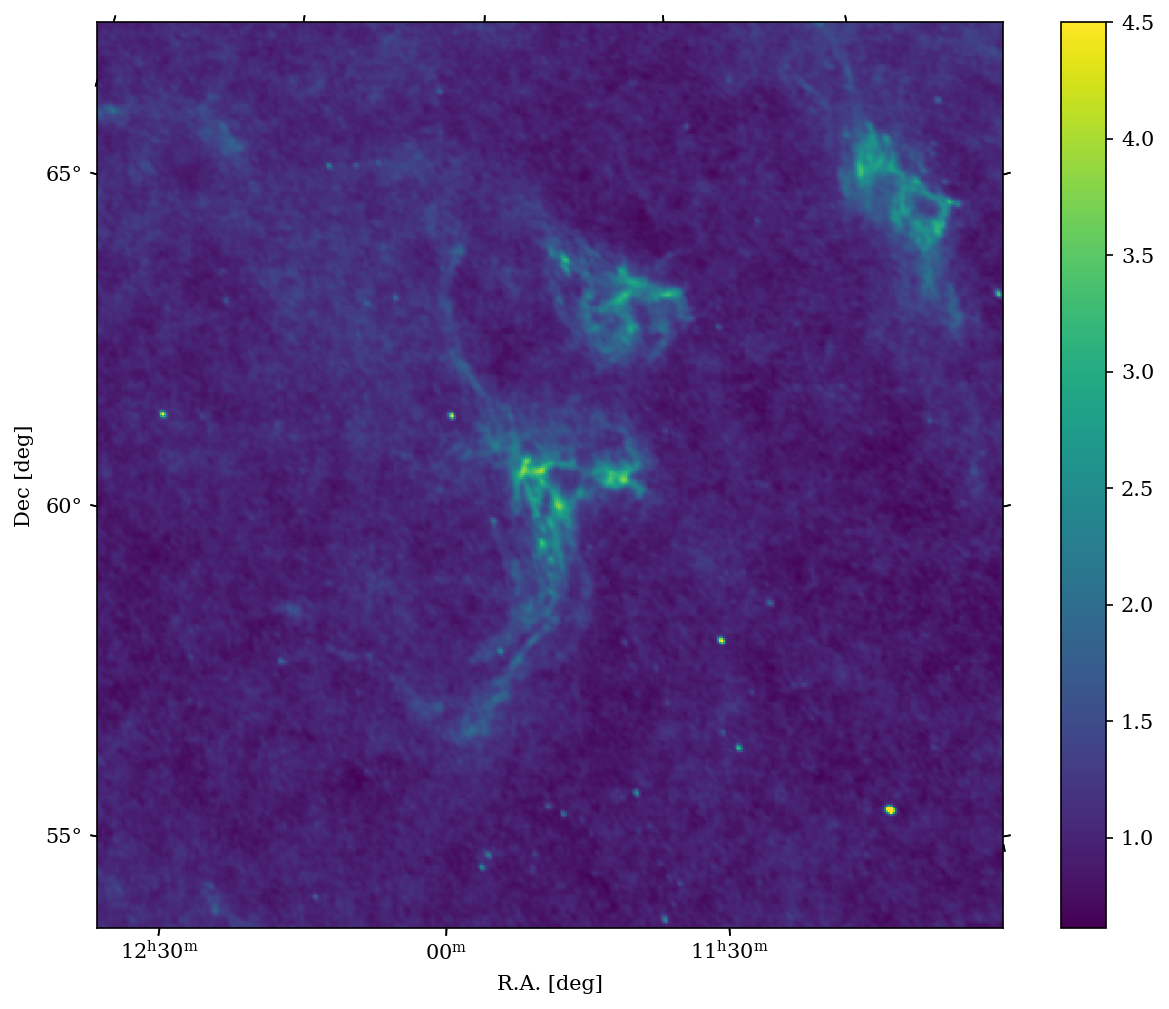

In [10]:
input_wcs = WCS(input_header)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=input_wcs)
lon, lat = ax.coords
im = ax.imshow(input_data, vmax=4.5, cmap='viridis', **imkw)
plt.colorbar(im, ax=ax)
lon.set_axislabel('R.A. [deg]')
lat.set_axislabel('Dec [deg]')

In [11]:
paths = SkyView().get_images(
    position='135., 54.',
    coordinates='galactic',
    pixels='300',
    scaling='Linear',
    survey=['EBHIS'],
    )

In [12]:
target_header, target_data = paths[0][0].header, paths[0][0].data

In [14]:
pprint(target_header)

SIMPLE  =                    T / Written by SkyView Mon Jun 28 07:34:47 EDT 2021
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                  300 / Width of image                                 
NAXIS2  =                  300 / Height of image                                
CRVAL1  =               135.25 / Reference longitude                            
CRVAL2  =                54.25 / Reference latitude                             
CTYPE1  = 'GLON-TAN'           / Coordinates -- projection                      
CTYPE2  = 'GLAT-TAN'           / Coordinates -- projection                      
CRPIX1  =                150.5 / X reference pixel                              
CRPIX2  =                150.5 / Y reference pixel                              
CDELT1  = -0.054272999999999995 / X scale                                       
CDELT2  = 0.0542729999999999

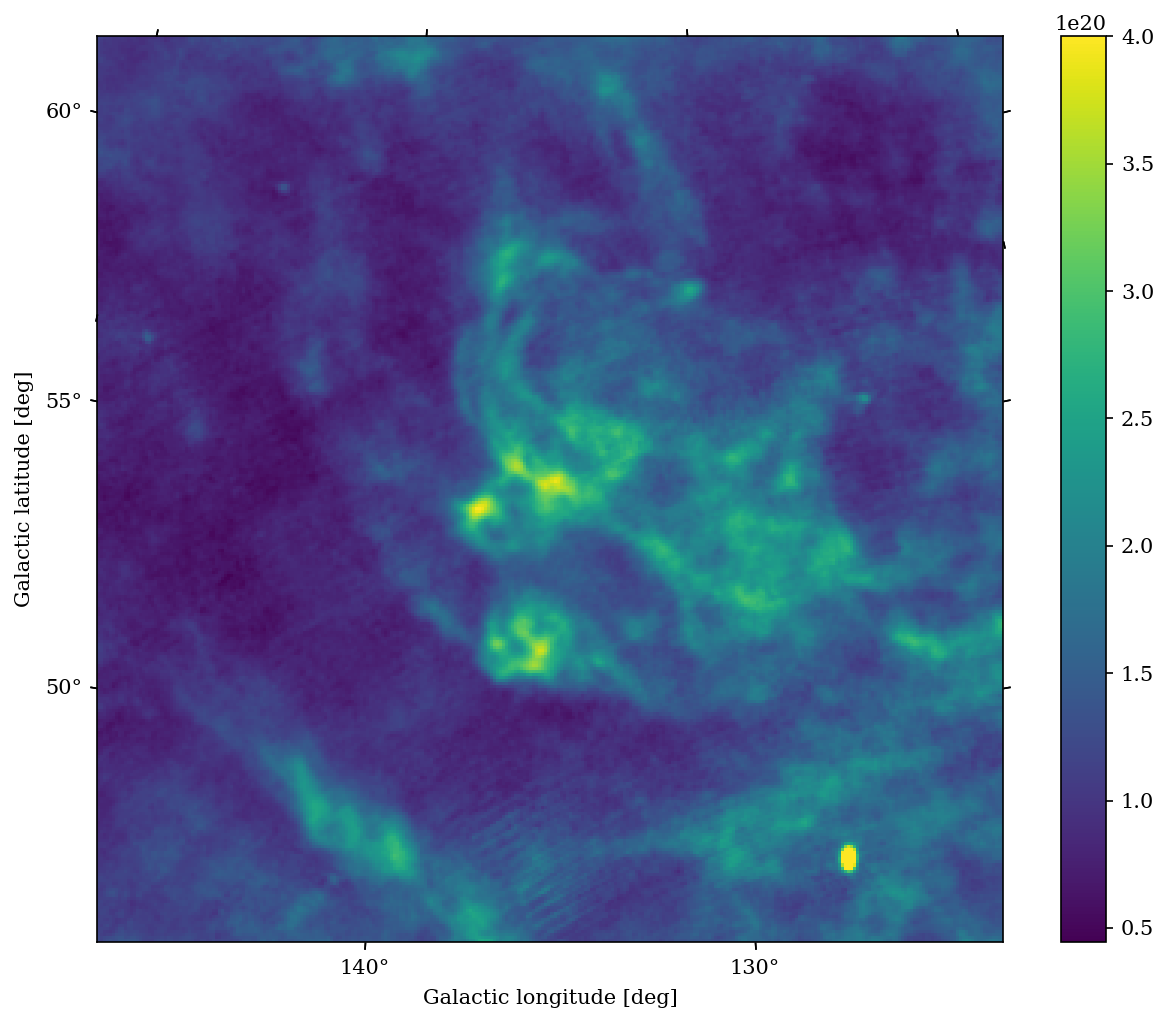

In [14]:
target_wcs = WCS(target_header)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=target_wcs)
lon, lat = ax.coords
im = ax.imshow(target_data, cmap='viridis', vmax=4.e20, **imkw)
plt.colorbar(im, ax=ax)
lon.set_axislabel('Galactic longitude [deg]')
lat.set_axislabel('Galactic latitude [deg]')

In [15]:
gridder = cygrid.WcsGrid(target_header)

In [16]:
input_lon_pix, input_lat_pix = np.meshgrid(
    np.arange(input_header['NAXIS1']),
    np.arange(input_header['NAXIS2'])
    )

In [17]:
input_lon_world, input_lat_world = input_wcs.all_pix2world(
    input_lon_pix, input_lat_pix, 0
    )

In [18]:
coords_eq = SkyCoord(
    input_lon_world, input_lat_world, frame='icrs', unit='deg'
    )
coords_gal = coords_eq.galactic

In [15]:
input_data.shape

(500, 500)

In [19]:
kernelsize_fwhm = 2.5/60.
# see https://en.wikipedia.org/wiki/Full_width_at_half_maximum
kernelsize_sigma = kernelsize_fwhm / np.sqrt(8 * np.log(2))
sphere_radius = 3. * kernelsize_sigma

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    sphere_radius,
    kernelsize_sigma / 2.
    )

In [20]:
gridder.grid(
    coords_gal.l.value.flatten(),
    coords_gal.b.value.flatten(),
    input_data.flatten(),
    )

<ipython-input-20-5dc78283f2b0>:1: UserWarning: Input data byteorder not native, will fix
  gridder.grid(


In [21]:
datacube = gridder.get_datacube()

<ipython-input-21-3e00e8b31cb4>:1: RuntimeWarning: invalid value encountered in true_divide
  datacube = gridder.get_datacube()


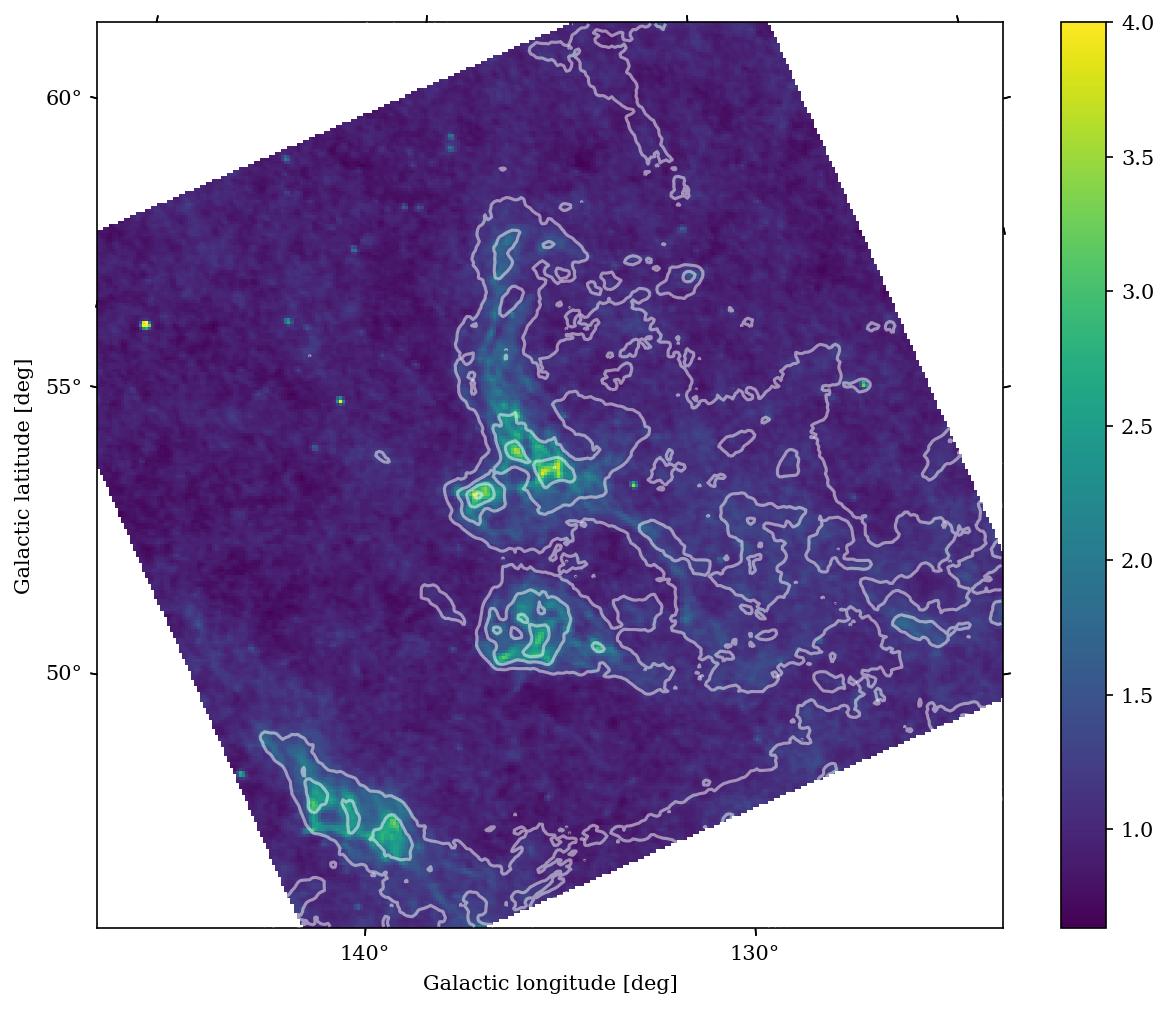

In [22]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=target_wcs)
lon, lat = ax.coords
im = ax.imshow(datacube, cmap='viridis', vmax=4., **imkw)
plt.colorbar(im, ax=ax)
ax.contour(
    target_data, colors='white',
    levels=np.arange(1.5e20, 1.e21, 8.e19), alpha=0.5
    )
lon.set_axislabel('Galactic longitude [deg]')
lat.set_axislabel('Galactic latitude [deg]')

## 

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from scipy.interpolate import griddata

import cygrid

In [21]:
imkw = dict(origin='lower', interpolation='nearest')

In [190]:
def setup_data(mapcenter, mapsize, vsize, beamsize_fwhm, num_samples, num_sources):
    '''
    Produce test data (including coords) - containing just noise and some point sources.
    
    Note: as in real astronomical measurements, the point sources are convolved with the
          instrument's response function (PSF), or telescope beam.
    '''

    lon_scale = np.cos(np.radians(mapcenter[1]))
    map_l, map_r = (
        mapcenter[0] - 1.1 * mapsize[0] / 2. / lon_scale,
        mapcenter[0] + 1.1 * mapsize[0] / 2. / lon_scale
        )
    map_b, map_t = mapcenter[1] - 1.1 * mapsize[1] / 2., mapcenter[1] + 1.1 * mapsize[1] / 2.
    
    # coordinates are drawn from a uniform distribution
    xcoords = np.random.uniform(map_l, map_r, num_samples).astype(np.float64)
    ycoords = np.random.uniform(map_b, map_t, num_samples).astype(np.float64)

    # add Gaussian noise
    signal = np.random.normal(0., 1., vsize*len(xcoords)).reshape(-1, vsize)
    
    beamsize_sigma = beamsize_fwhm / np.sqrt(8 * np.log(2))
    
    # put in artifical point source, with random amplitudes
    # we'll assume a Gaussian-shaped PSF
    
    def gauss2d(x, y, x0, y0, A, s):
        return A * np.exp(-((x-x0)**2 + (y-y0)**2) / 2. / s**2)
    
    for i in range(vsize):
        sou_x = np.random.uniform(map_l, map_r, num_sources).astype(np.float64)
        sou_y = np.random.uniform(map_b, map_t, num_sources).astype(np.float64)
        for _ in range(num_sources):

            A = np.random.uniform(5, 10, 1)
            signal[:, i] = signal[:, i] + gauss2d(xcoords, ycoords, sou_x[_], sou_y[_], A, beamsize_sigma)

    return xcoords, ycoords, signal

In [191]:
mapcenter = 60., 30.  # all in degrees
mapsize = 5., 7.
vsize = 6
beamsize_fwhm = 0.1
num_samples = 10 ** 6
num_sources = 10

xcoords, ycoords, signal = setup_data(
    mapcenter, mapsize, vsize, beamsize_fwhm, num_samples, num_sources
    )

In [192]:
signal.shape

(1000000, 6)

In [193]:
def setup_header(mapcenter, mapsize, vsize, beamsize_fwhm):
    '''
    Produce a FITS header that contains the target field.
    '''
    
    # define target grid (via fits header according to WCS convention)
    # a good pixel size is a third of the FWHM of the PSF (avoids aliasing)
    pixsize = beamsize_fwhm / 3.
    dnaxis1 = int(mapsize[0] / pixsize)
    dnaxis2 = int(mapsize[1] / pixsize)

    header = {
        'NAXIS': 3,
        'NAXIS1': dnaxis1,
        'NAXIS2': dnaxis2,
        'NAXIS3': vsize,
        'CTYPE1': 'RA---SIN',
        'CUNIT1': 'deg',
        'CDELT1': -pixsize,
        'CRPIX1': dnaxis1 / 2.,
        'CRVAL1': mapcenter[0],
        'CTYPE2': 'DEC--SIN',
        'CUNIT2': 'deg',
        'CDELT2': pixsize,
        'CRPIX2': dnaxis2 / 2.,
        'CRVAL2': mapcenter[1],
        'CTYPE3': 'VOBS',
        'CUNIT3': 'K',
        'CDELT3': 1,
        'CRPIX3': vsize / 2.,
        'CRVAL3': 0,
        }
    
    return header

In [194]:
target_header = setup_header(mapcenter, mapsize, vsize, beamsize_fwhm)

# let's already define a WCS object for later use in our plots:
target_wcs = WCS(target_header)

In [195]:
gridder = cygrid.WcsGrid(target_header)

In [196]:
kernelsize_fwhm = 2.5 / 60.  # degrees
# see https://en.wikipedia.org/wiki/Full_width_at_half_maximum
kernelsize_sigma = kernelsize_fwhm / np.sqrt(8 * np.log(2))
sphere_radius = 3. * kernelsize_sigma

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    sphere_radius,
    kernelsize_sigma / 2.
    )

In [197]:
gridder.grid(xcoords, ycoords, signal)

In [198]:
cygrid_map = gridder.get_datacube()

In [199]:
cygrid_map.shape

(6, 210, 150)

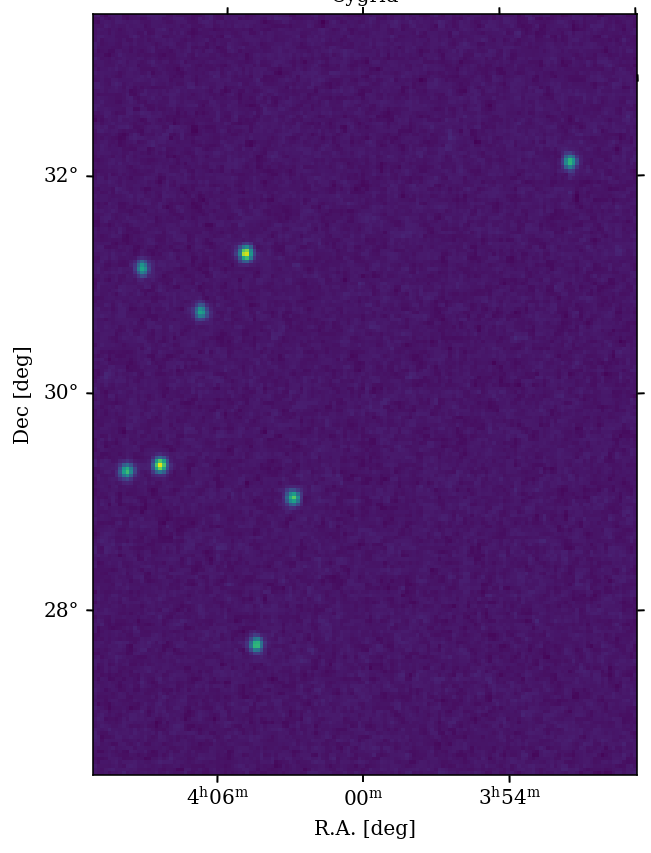

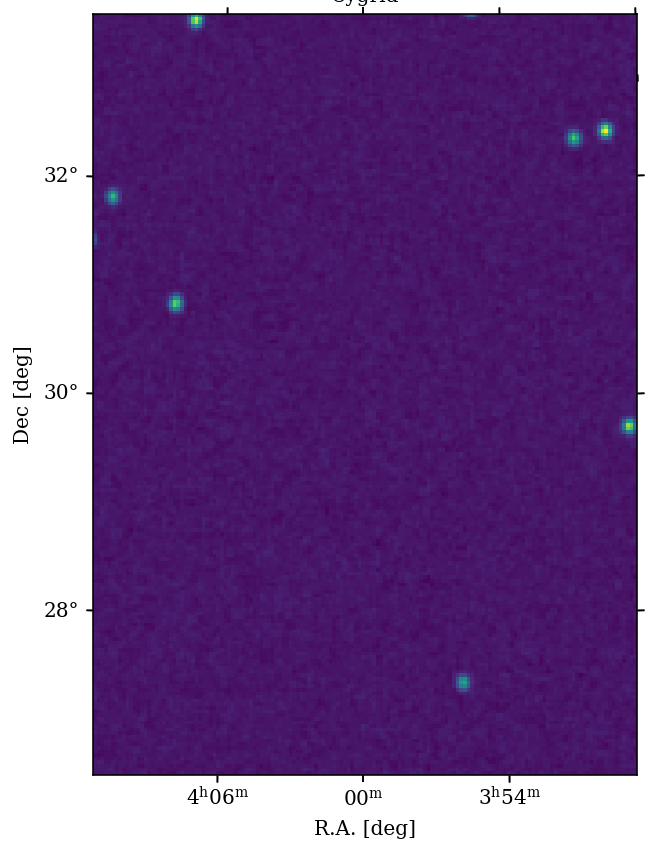

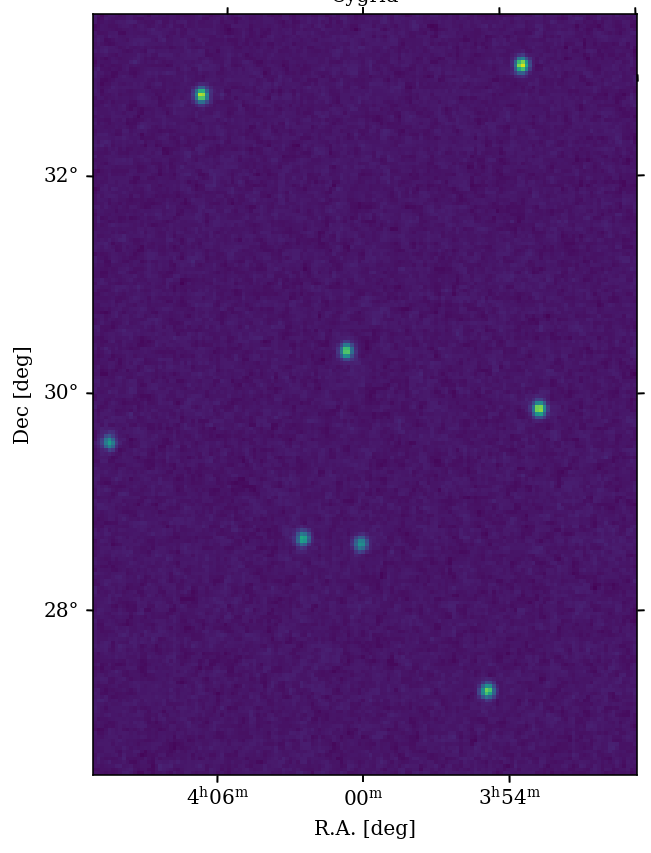

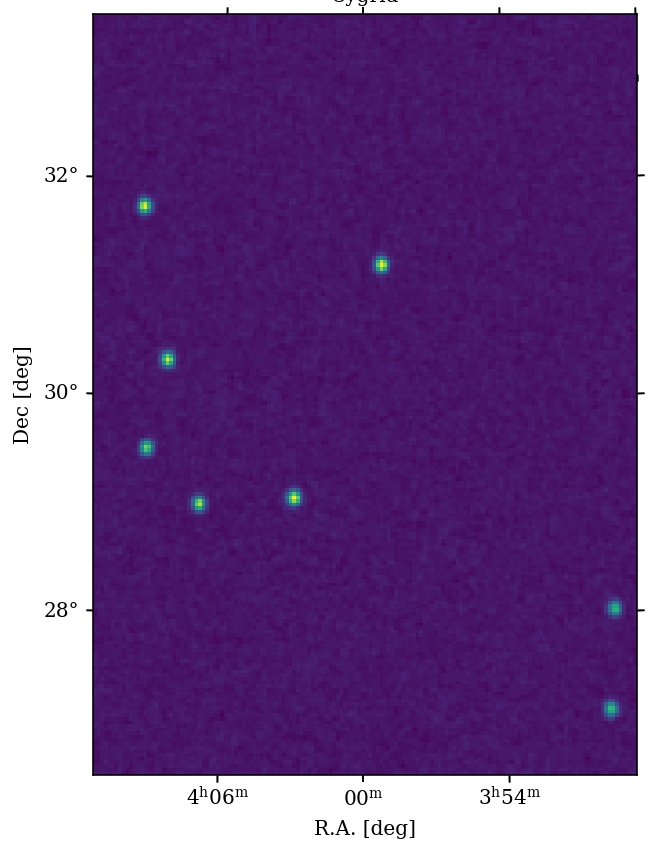

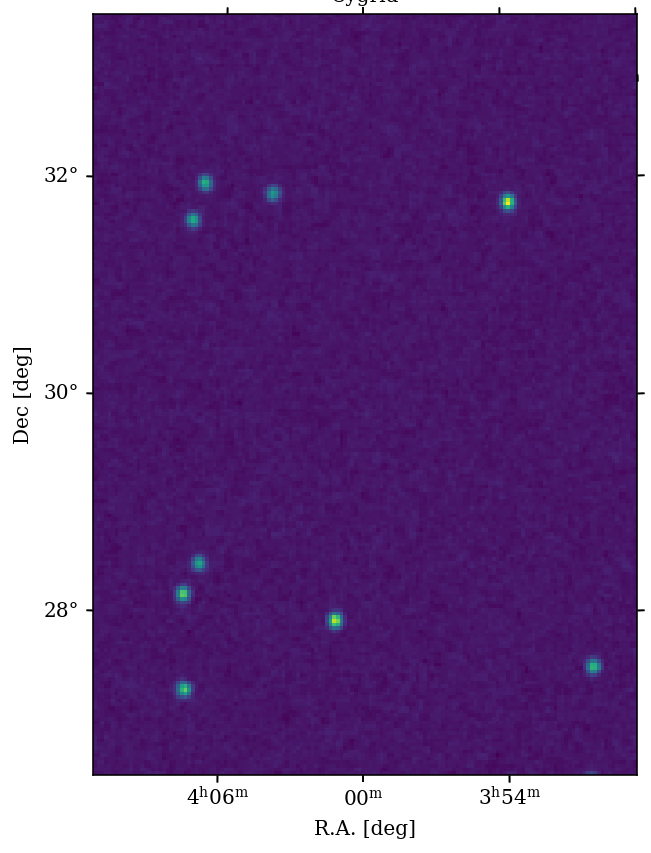

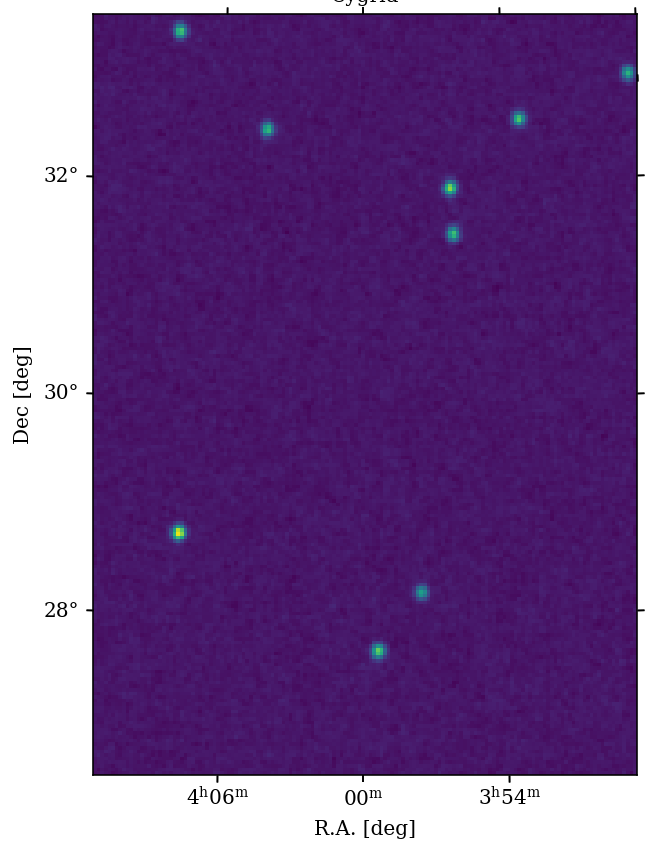

In [200]:
for cymap in cygrid_map:
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(111, projection=target_wcs.celestial)
    ax1.imshow(cymap, vmin=-0.5, vmax=8.0, **imkw)
    ax1.set_title('Cygrid')
    lon, lat = ax1.coords
    lon.set_axislabel('R.A. [deg]')
    lat.set_axislabel('Dec [deg]')
    plt.show()

## 

## RMS calculation

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from pprint import pprint
from copy import copy
from copy import deepcopy

<ipython-input-32-87341d1b3dc3>:10: RuntimeWarning: Mean of empty slice
  med = np.nanmean(raw_data, axis=2)


mean [[ 0.04896365  0.03482359  0.02557112 ...  0.03414182  0.03928609
   0.04896365]
 [ 0.05584328  0.03311481  0.01283016 ...  0.05951769  0.05650734
   0.05584328]
 [ 0.02562419  0.00679147 -0.01193501 ...  0.00730367  0.01700916
   0.02562419]
 ...
 [ 0.00663656  0.00042982 -0.00569056 ...  0.00453148  0.00298421
   0.00663656]
 [-0.00216666  0.00029255  0.00285582 ...  0.01016253  0.00530181
  -0.00216666]
 [-0.0109101   0.0002638   0.01150188 ...  0.01586821  0.0076902
  -0.0109101 ]] K
std for data < median: 0.07968887 K


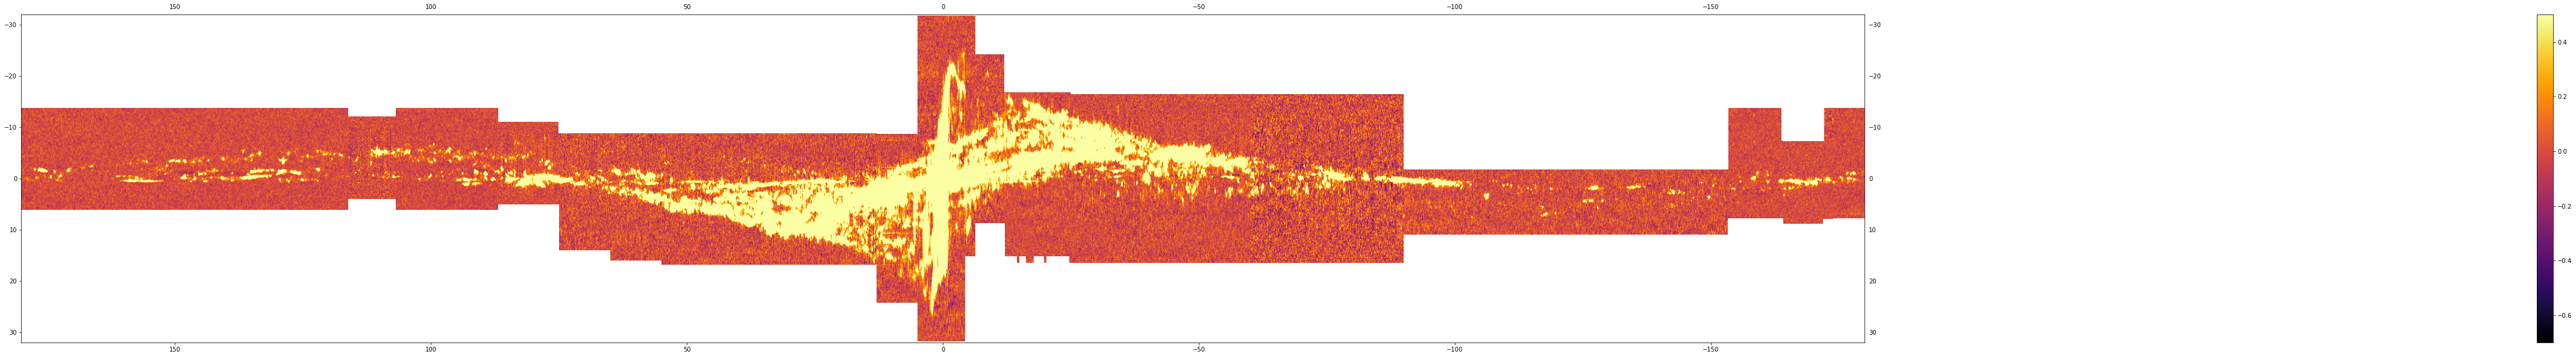

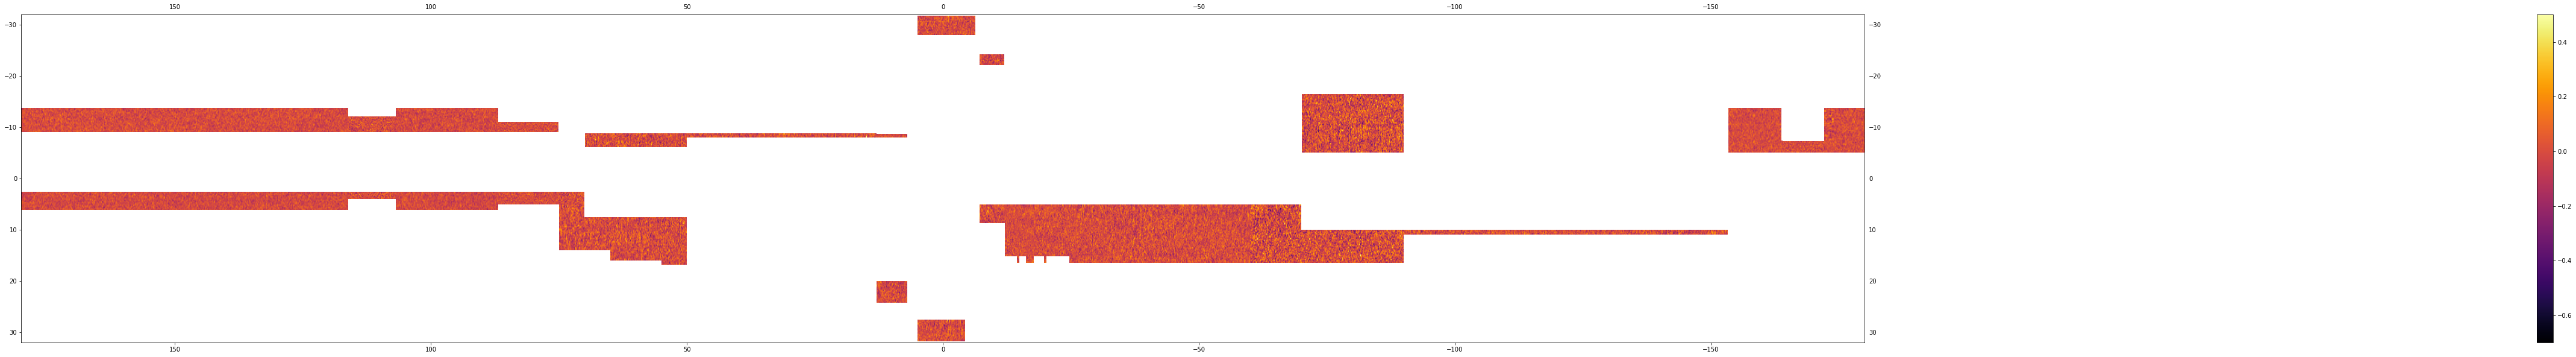

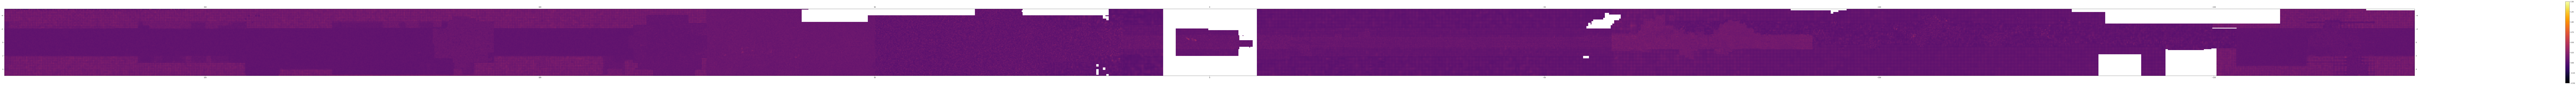

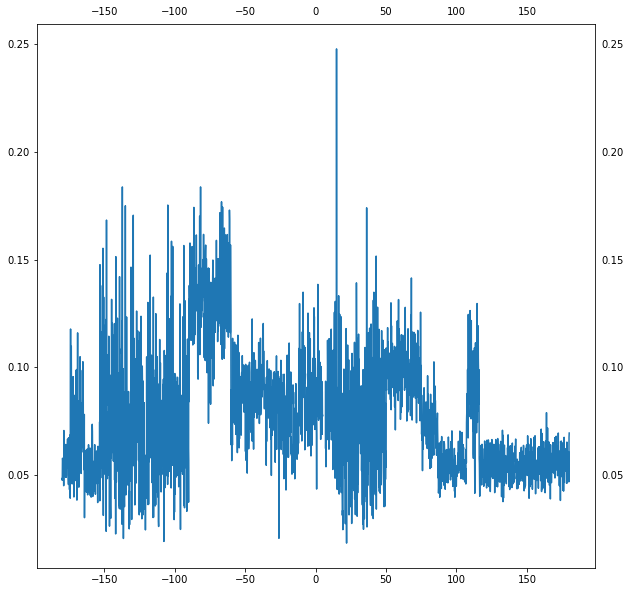

In [32]:
vel_obs = -300
lat_obs = 0
mean = True

i_vel = np.argmin(np.abs(vel_lsr-vel_obs))
i_lat = np.argmin(np.abs(glat-lat_obs))

raw_data = cogal[0].data
if mean:
    med = np.nanmean(raw_data, axis=2)
    print('mean', med, 'K')
else:
    med = np.nanmedian(raw_data, axis=2)
    print('median', med, 'K')
print('std for data < median:', raw_data[raw_data < med.reshape(*med.shape, 1)].std(), 'K')

clean_noise = deepcopy(raw_data)

rms_mask=np.zeros_like(raw_data)
# i_mask = raw_data > med
# rms_mask[i_mask] = 1
i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=-180)&(glon<-70))[0].reshape(1, -1, 1), np.where((vel_lsr>=-50)&(vel_lsr<=100))[0].reshape(1, 1, -1), )
rms_mask[i_mask] = 1
i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=-70)&(glon<-7))[0].reshape(1, -1, 1), np.where((vel_lsr>=-220)&(vel_lsr<=50))[0].reshape(1, 1, -1), )
rms_mask[i_mask] = 1
i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=-7)&(glon<7))[0].reshape(1, -1, 1), np.where((vel_lsr>=-280)&(vel_lsr<=275))[0].reshape(1, 1, -1), )
rms_mask[i_mask] = 1
i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=7)&(glon<50))[0].reshape(1, -1, 1), np.where((vel_lsr>=-80)&(vel_lsr<=200))[0].reshape(1, 1, -1), )
rms_mask[i_mask] = 1
i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=50)&(glon<70))[0].reshape(1, -1, 1), np.where((vel_lsr>=-60)&(vel_lsr<=75))[0].reshape(1, 1, -1), )
rms_mask[i_mask] = 1
i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=70)&(glon<=180))[0].reshape(1, -1, 1), np.where((vel_lsr>=-90)&(vel_lsr<=25))[0].reshape(1, 1, -1), )
rms_mask[i_mask] = 1

clean_data = np.ma.masked_array(raw_data, rms_mask)
clean_noise[clean_data.mask] = np.nan
rms = np.nanstd(clean_noise, axis=2)

fig, ax = plt.subplots(1, 1, figsize=(400, 10))
cm = ax.imshow(raw_data[i_lat, :, :].T, vmax=0.5, cmap='inferno', extent=[glon.max(), glon.min(), vel_lsr.max()/10, vel_lsr.min()/10])
fig.colorbar(cm)
ax.tick_params(labeltop=True, labelright=True)

fig, ax = plt.subplots(1, 1, figsize=(400, 10))
cm = ax.imshow(clean_data[i_lat, :, :].T, vmax=0.5, cmap='inferno', extent=[glon.max(), glon.min(), vel_lsr.max()/10, vel_lsr.min()/10])
fig.colorbar(cm)
ax.tick_params(labeltop=True, labelright=True)

fig, ax = plt.subplots(1, 1, figsize=(360, 10))
cm = ax.imshow(rms, cmap='inferno', extent=[glon.max(), glon.min(), glat.max(), glat.min()], vmin=-0.5, vmax=1.5)
fig.colorbar(cm)
ax.tick_params(labeltop=True, labelright=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(glon, rms[i_lat, :])
ax.tick_params(labeltop=True, labelright=True)

/home/yanitski/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


median [[ 0.04777718  0.03499174  0.02405691 ...  0.03532839  0.01463604
   0.04777718]
 [ 0.02456188  0.0163188   0.00100994 ...  0.02977657  0.00942135
   0.02456188]
 [ 0.03162718 -0.0021863  -0.0272522  ...  0.00807571 -0.00723362
   0.03162718]
 ...
 [-0.01345825 -0.00605583 -0.00100899 ...  0.009758    0.00706577
  -0.01345825]
 [-0.00841093  0.00050497 -0.00504637 ...  0.01547718 -0.01160717
  -0.00841093]
 [ 0.00370169 -0.01766348 -0.00151348 ...  0.01884174 -0.00504684
   0.00370169]] K
std for data < median: 0.0650586 K


/home/yanitski/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


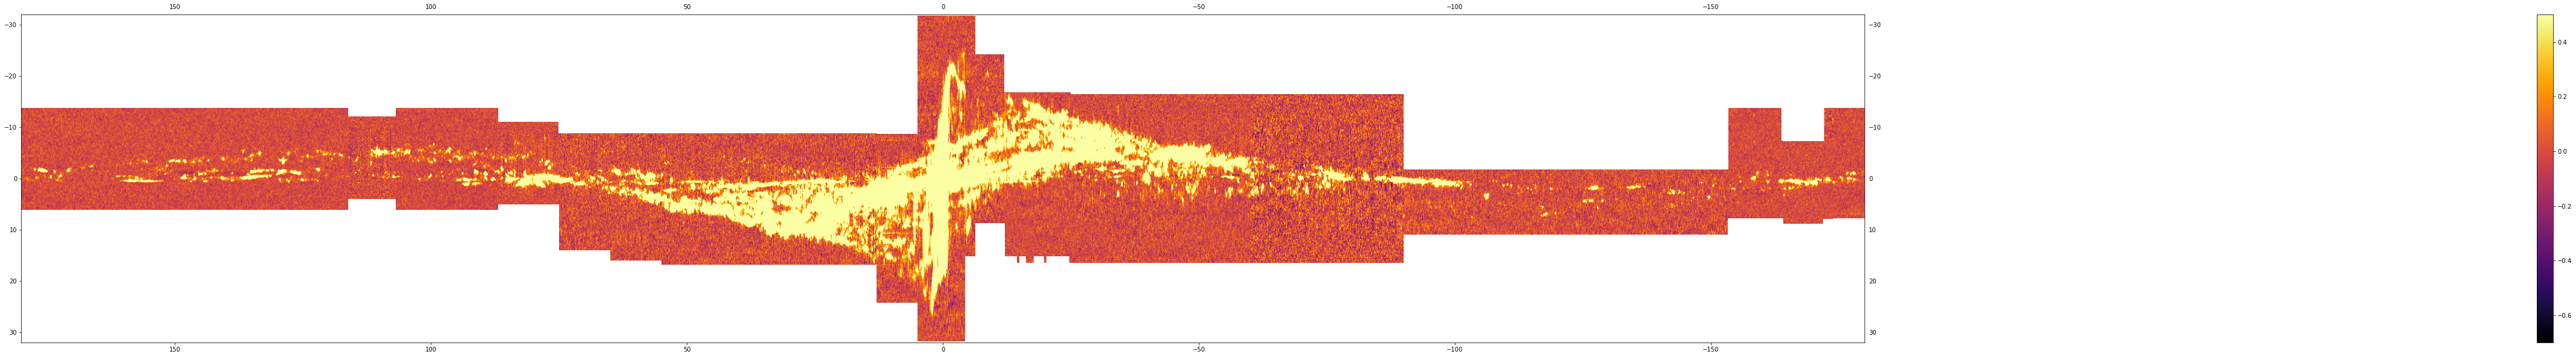

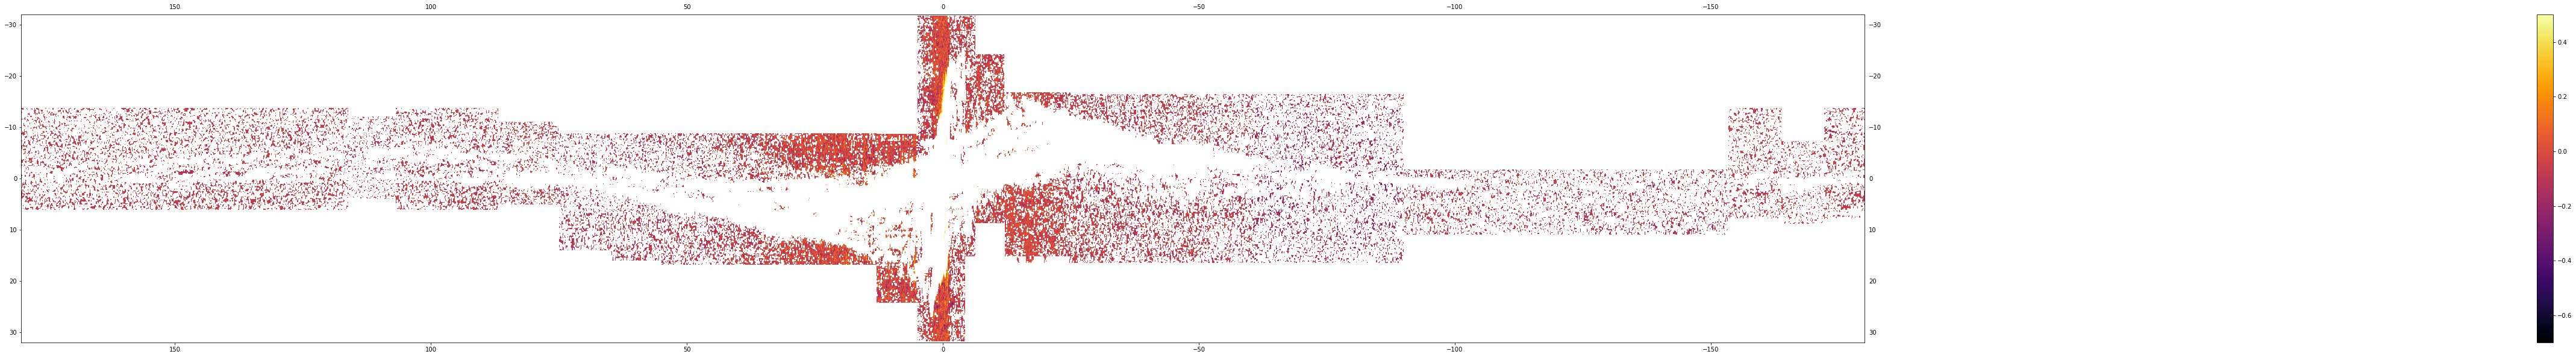

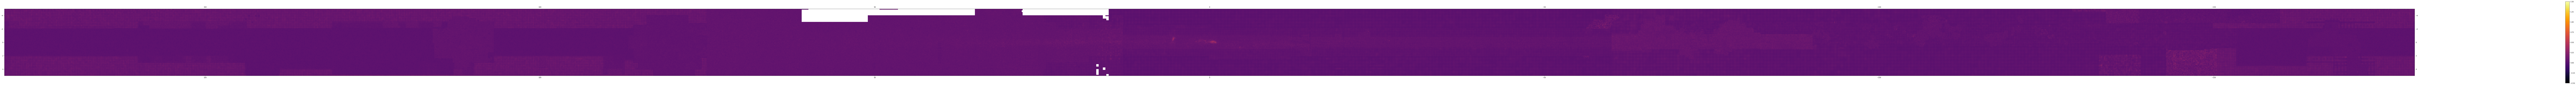

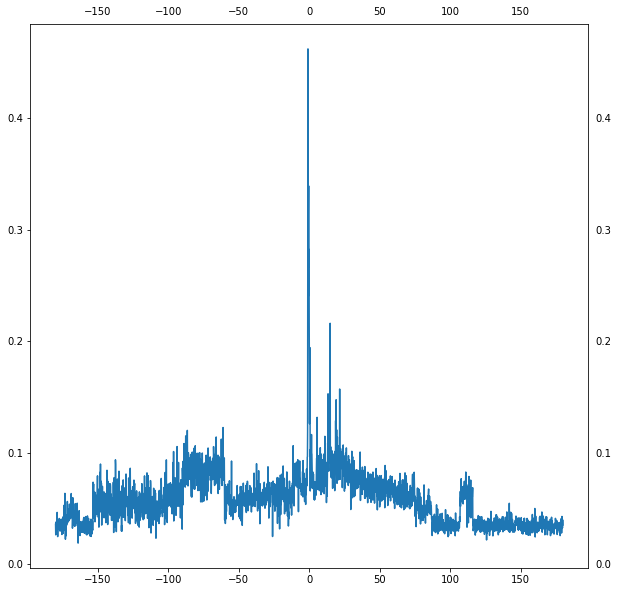

In [35]:
vel_obs = -300
lat_obs = 0
mean = False

i_vel = np.argmin(np.abs(vel_lsr-vel_obs))
i_lat = np.argmin(np.abs(glat-lat_obs))

raw_data = cogal[0].data
if mean:
    med = np.nanmean(raw_data, axis=2)
    print('mean', med, 'K')
else:
    med = np.nanmedian(raw_data, axis=2)
    print('median', med, 'K')
print('std for data < median:', raw_data[raw_data < med.reshape(*med.shape, 1)].std(), 'K')

clean_noise = deepcopy(raw_data)

rms_mask=np.zeros_like(raw_data)
i_mask = raw_data > med.reshape(*med.shape, 1)
rms_mask[i_mask] = 1
# i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=-180)&(glon<-70))[0].reshape(1, -1, 1), np.where((vel_lsr>=-50)&(vel_lsr<=100))[0].reshape(1, 1, -1), )
# rms_mask[i_mask] = 1
# i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=-70)&(glon<-7))[0].reshape(1, -1, 1), np.where((vel_lsr>=-220)&(vel_lsr<=50))[0].reshape(1, 1, -1), )
# rms_mask[i_mask] = 1
# i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=-7)&(glon<7))[0].reshape(1, -1, 1), np.where((vel_lsr>=-280)&(vel_lsr<=275))[0].reshape(1, 1, -1), )
# rms_mask[i_mask] = 1
# i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=7)&(glon<50))[0].reshape(1, -1, 1), np.where((vel_lsr>=-80)&(vel_lsr<=200))[0].reshape(1, 1, -1), )
# rms_mask[i_mask] = 1
# i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=50)&(glon<70))[0].reshape(1, -1, 1), np.where((vel_lsr>=-60)&(vel_lsr<=75))[0].reshape(1, 1, -1), )
# rms_mask[i_mask] = 1
# i_mask = (np.where((glat<=90)&(glat>=-90))[0].reshape(-1, 1, 1), np.where((glon>=70)&(glon<=180))[0].reshape(1, -1, 1), np.where((vel_lsr>=-90)&(vel_lsr<=25))[0].reshape(1, 1, -1), )
# rms_mask[i_mask] = 1

clean_data = np.ma.masked_array(raw_data, rms_mask)
clean_noise[clean_data.mask] = np.nan
rms = np.nanstd(clean_noise, axis=2)

fig, ax = plt.subplots(1, 1, figsize=(400, 10))
cm = ax.imshow(raw_data[i_lat, :, :].T, vmax=0.5, cmap='inferno', extent=[glon.max(), glon.min(), vel_lsr.max()/10, vel_lsr.min()/10])
fig.colorbar(cm)
ax.tick_params(labeltop=True, labelright=True)

fig, ax = plt.subplots(1, 1, figsize=(400, 10))
cm = ax.imshow(clean_data[i_lat, :, :].T, vmax=0.5, cmap='inferno', extent=[glon.max(), glon.min(), vel_lsr.max()/10, vel_lsr.min()/10])
fig.colorbar(cm)
ax.tick_params(labeltop=True, labelright=True)

fig, ax = plt.subplots(1, 1, figsize=(360, 10))
cm = ax.imshow(rms, cmap='inferno', extent=[glon.max(), glon.min(), glat.max(), glat.min()], vmin=-0.5, vmax=1.5)
fig.colorbar(cm)
ax.tick_params(labeltop=True, labelright=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(glon, rms[i_lat, :])
ax.tick_params(labeltop=True, labelright=True)

In [41]:
np.broadcast(np.arange(4), [[1], [2]]).shape

(2, 4)

In [32]:
data = fits.open('/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/Mopra/regridded/temp/co1_test_regridded_error.fits')

(181, 361)


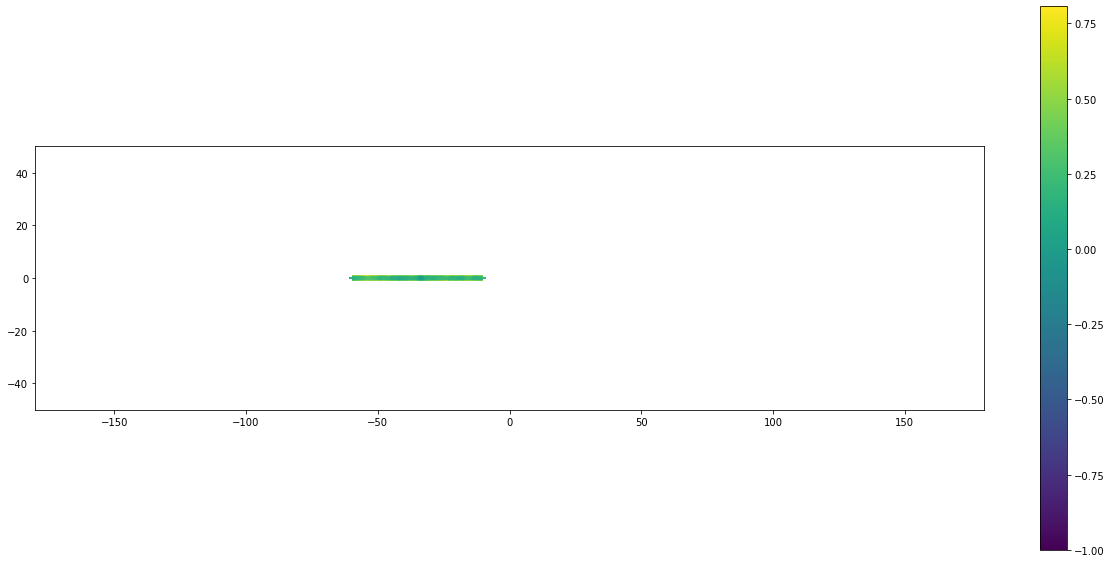

In [35]:
obs = copy(data[0].data[:, :])
print(obs.shape)
# obs[obs == 0] = np.nan
plt.figure(figsize=(20, 10))
plt.imshow(np.log10(obs), extent=(-180, 180, -50, 50), vmin=-1)
plt.colorbar(fraction=0.1)

In [45]:
np.concatenate(([100], [10], [-30], [20], [0, 1, 2]), axis=0)

array([100,  10, -30,  20,   0,   1,   2])

In [130]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes.frame import EllipticalFrame

file = fits.open('/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/ThrUMMS/regridded/temp/co1_test_regridded_error.fits')[0]
header = file.header
data = file.data

In [131]:
data.shape

(701, 181, 361)

In [126]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  361                                                  
NAXIS2  =                  181                                                  
CTYPE1  = 'GLON-CAR'                                                            
CRVAL1  =                    0                                                  
CDELT1  =                    1                                                  
CRPIX1  =                  181                                                  
CTYPE2  = 'GLAT-CAR'                                                            
CRVAL2  =                    0                                                  
CDELT2  =                    1                                                  
CRPIX2  =                   

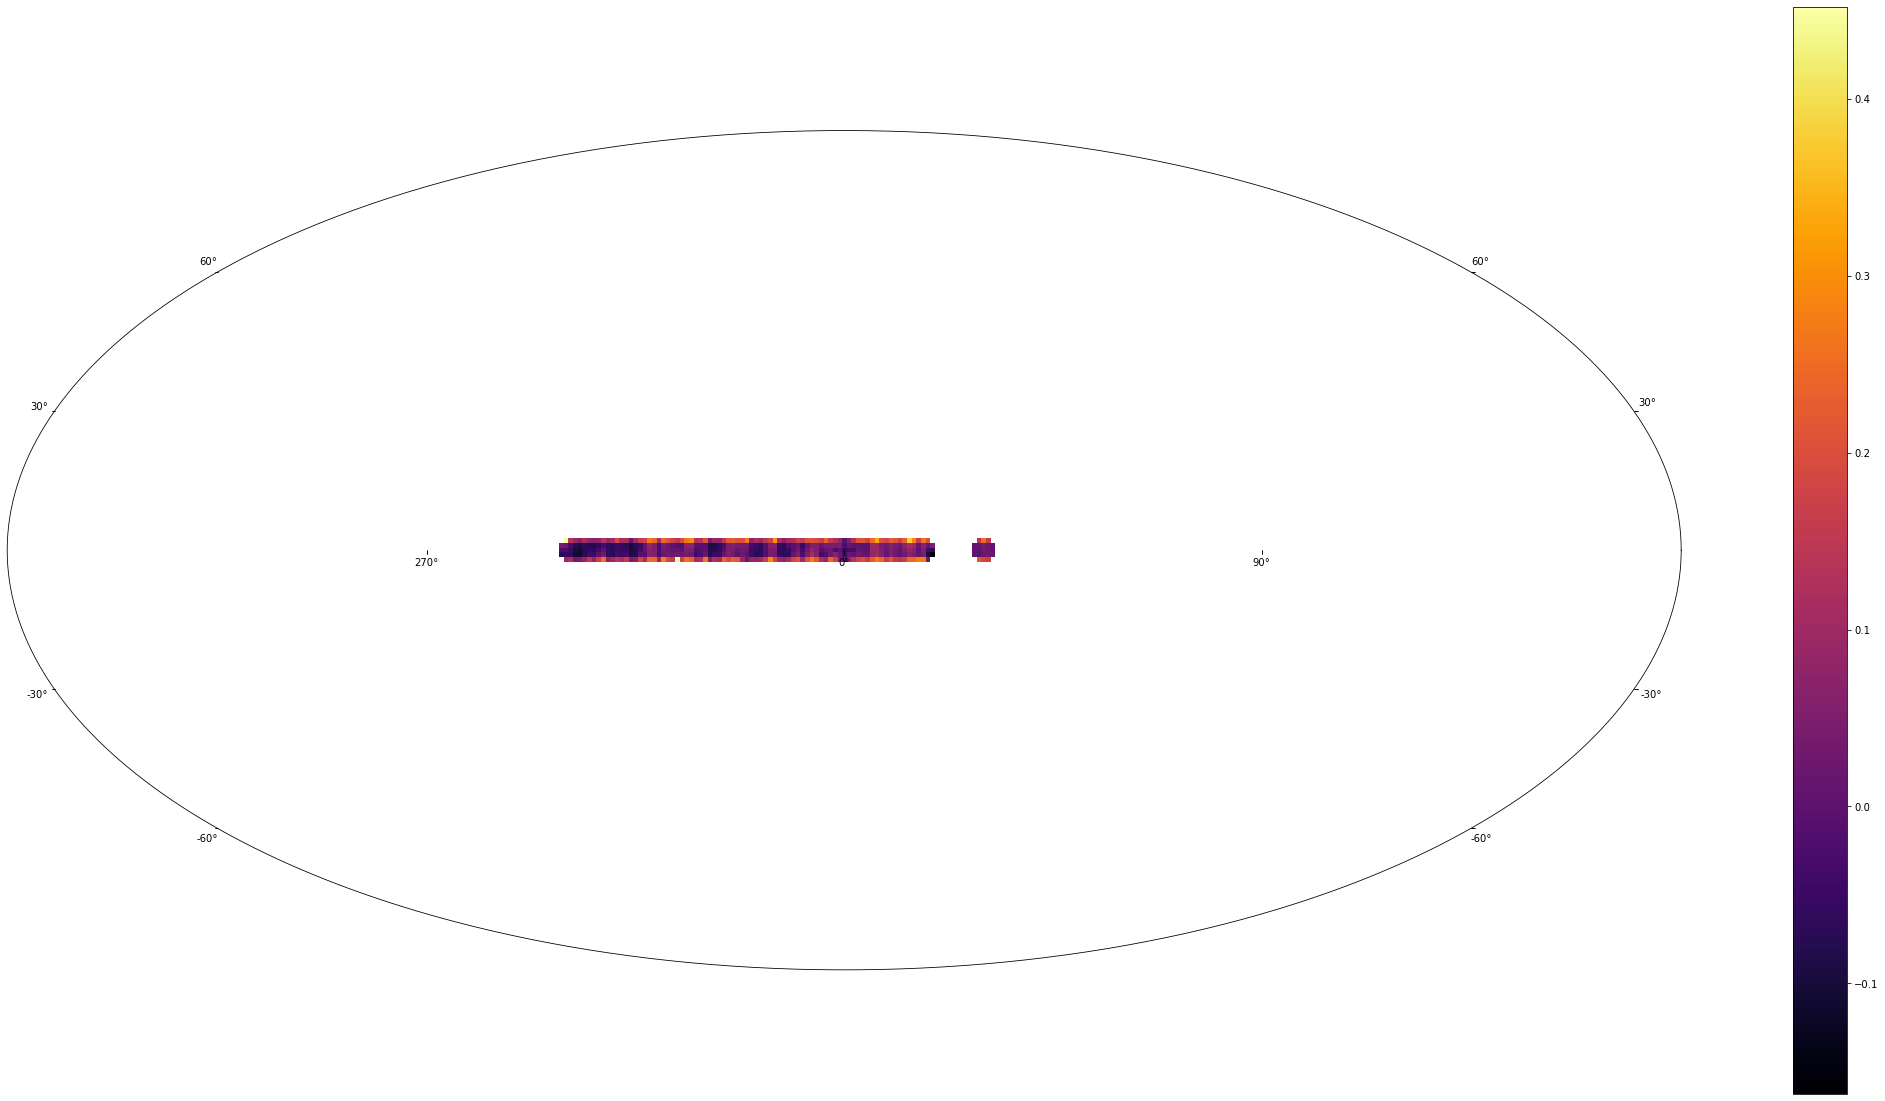

In [125]:
if 'CTYPE3' in header.keys():
    del header['CTYPE3']
    del header['CRVAL3']
    del header['CDELT3']
    del header['CRPIX3']

fig, ax = plt.subplots(1, 1, figsize=(40, 20), subplot_kw=dict(projection=WCS(header), frame_class=EllipticalFrame))
cm = ax.imshow(np.log10(data), cmap='inferno')
fig.colorbar(cm, fraction=0.2)
# ax.set_aspect(0.5)
plt.show()
plt.close()

In [13]:
np.isnan(data[:5, 0])

array([ True,  True,  True,  True,  True])

In [7]:
(data != np.nan).all()

True

In [5]:
data[data != np.nan]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)